In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# Mod_count_data is data pulled from MySQL dump
mod_count_data = pd.read_csv("mod_data.txt", delimiter = "\t")
mod_count_data['timestamp'] = pd.to_datetime(mod_count_data['timestamp'], errors='coerce')

# Subscribers data
subscribers_count_data = pd.read_csv("meta_data.txt", delimiter = "\t")
subscribers_count_data['timestamp'] = pd.to_datetime(subscribers_count_data['timestamp'], errors='coerce')
sorted_sub_data = subscribers_count_data.sort_values(by=['subreddit', 'timestamp'])

# Sorting data from alphabetical and earliest time stamp to latest
sorted_mod_data = mod_count_data.sort_values(by=['subreddit', 'timestamp'])
sorted_mod_data["time_diff"] = sorted_mod_data.groupby(['subreddit'])["timestamp"].diff()
sorted_mod_data["mod_diff"] = sorted_mod_data.groupby(['subreddit'])["num_mods"].diff()
sorted_mod_data["mod_diff"] = sorted_mod_data["mod_diff"].fillna(0)
sorted_mod_data = sorted_mod_data.reset_index()

In [3]:
# Selects an individual subreddit
def select_subreddit(subreddit, data):
    filtered_data = data[data["subreddit"] == (subreddit)]
    return filtered_data

In [4]:
# Function that creates the mods_gained and mods_lost columns. Looks at json mod data and compares unique names from
# two different timestamps on a subreddit. The first instance of a subreddit will results in 0 mods_gained and 0 mods_lost.
def mod_churn(df):    
    # unpacks mods_json column
    new_df = df.join(df['mods_json'].apply(json.loads).apply(pd.Series))
    data = new_df['data']
    
    # creating sets to compare names with
    set1 = set()
    set2 = set()
    
    # gained and lost arrays will be returned and turned into columns
    gained = []
    lost = []

    for x in data:
        set2 = set()
        for y in x['children']:
            name = y['name']
            set2.add(name)
        if(len(set1) == 0):
            gained.append(0)
            lost.append(0)
        else:
            diff = 0
            for name in set1:
                if(name not in set2):
                    diff += 1
            lost.append(diff)
            diff = 0
            for name in set2:
                if(name not in set1):
                    diff += 1
            gained.append(diff)
        set1 = set2.copy()
    return gained, lost

In [5]:
unique_subreddits = sorted_mod_data['subreddit'].unique()

In [6]:
ultra_gained = []
ultra_lost = []
for x in unique_subreddits:
    df = select_subreddit(x, sorted_mod_data)
    mods_gained, mods_lost = mod_churn(df)
    ultra_gained.append(mods_gained)
    ultra_lost.append(mods_lost)

In [7]:
ultra_gained_list = [j for sub in ultra_gained for j in sub]
ultra_lost_list = [j for sub in ultra_lost for j in sub]

In [8]:
sorted_mod_data['mods_gained'] = ultra_gained_list
sorted_mod_data['mods_lost'] = ultra_lost_list
sorted_mod_data

,index,subreddit,timestamp,mods_json,num_mods,time_diff,mod_diff,mods_gained,mods_lost
0,80,4chanmeta,2020-10-03 03:00:22,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",15,NaT,0.0,0,0
1,284,4chanmeta,2020-11-15 23:14:32,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,43 days 20:14:10,-1.0,0,1
2,533,4chanmeta,2020-11-27 03:28:12,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,11 days 04:13:40,0.0,0,0
3,738,4chanmeta,2020-12-31 01:15:31,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,33 days 21:47:19,0.0,0,0
4,943,4chanmeta,2021-01-22 18:45:19,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,22 days 17:29:48,0.0,0,0
...,...,...,...,...,...,...,...,...,...
3404,2514,youtubecomments,2021-12-09 06:41:32,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",12,24 days 00:10:54,0.0,0,0
3405,2718,youtubecomments,2022-01-08 12:05:42,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",11,30 days 05:24:10,-1.0,0,1
3406,2922,youtubecomments,2022-02-09 17:01:58,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",11,32 days 04:56:16,0.0,0,0
3407,3125,youtubecomments,2022-03-14 14:43:57,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",11,32 days 21:41:59,0.0,0,0


In [9]:
total_df = sorted_mod_data.groupby(['subreddit']).sum().reset_index()
print(total_df)

                 subreddit  index  num_mods  mod_diff  mods_gained  mods_lost
0                4chanmeta  29795       247      -1.0            1          2
1               7daystodie  29885       165      -1.0            1          2
2                 90smusic  29287       162       0.0            1          1
3                 absolver  27017        48       0.0            0          0
4                aerospace  28403        51       0.0            0          0
..                     ...    ...       ...       ...          ...        ...
201  wholesomestarterpacks  27245       112       0.0            0          0
202               winnipeg  28624       203      -2.0            0          2
203               witcher3  29911        67      -2.0            1          3
204                  words  28507        34       0.0            0          0
205        youtubecomments  29014       218      -3.0            0          3

[206 rows x 6 columns]


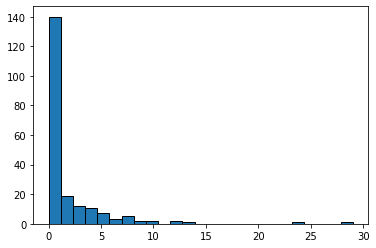

In [10]:
plt.hist(total_df['mods_gained'], edgecolor = 'black', bins = 25)
plt.show()

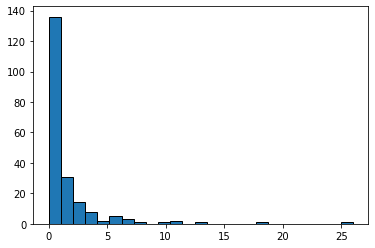

In [11]:
plt.hist(total_df['mods_lost'], edgecolor = 'black', bins = 25)
plt.show()

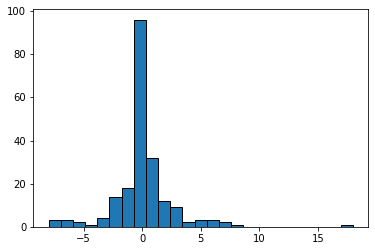

In [12]:
plt.hist(total_df['mod_diff'], edgecolor = 'black', bins = 25)
plt.show()

In [13]:
joined_df = pd.merge(sorted_mod_data,sorted_sub_data[['timestamp','num_subscribers']],on='timestamp', how='left')
joined_df['time_diff_float'] = (joined_df['time_diff'].dt.total_seconds()) / 86400
joined_df.head(17)

,index,subreddit,timestamp,mods_json,num_mods,time_diff,mod_diff,mods_gained,mods_lost,num_subscribers,time_diff_float
0,80,4chanmeta,2020-10-03 03:00:22,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",15,NaT,0.0,0,0,24784.0,NaN
1,284,4chanmeta,2020-11-15 23:14:32,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,43 days 20:14:10,-1.0,0,1,24888.0,43.843171
2,533,4chanmeta,2020-11-27 03:28:12,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,11 days 04:13:40,0.0,0,0,24915.0,11.176157
3,738,4chanmeta,2020-12-31 01:15:31,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,33 days 21:47:19,0.0,0,0,NaN,33.907859
4,943,4chanmeta,2021-01-22 18:45:19,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,22 days 17:29:48,0.0,0,0,25244.0,22.729028
5,1147,4chanmeta,2021-02-22 10:22:29,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,30 days 15:37:10,0.0,0,0,25579.0,30.650810
6,1351,4chanmeta,2021-04-15 09:15:17,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,51 days 22:52:48,0.0,0,0,25948.0,51.953333
7,1555,4chanmeta,2021-05-13 16:51:16,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",14,28 days 07:35:59,0.0,0,0,26109.0,28.316655
8,1758,4chanmeta,2021-09-04 13:24:02,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",15,113 days 20:32:46,1.0,1,0,26630.0,113.856088
9,1962,4chanmeta,2021-09-28 15:29:41,"{""kind"": ""UserList"", ""data"": {""children"": [{""n...",15,24 days 02:05:39,0.0,0,0,26716.0,24.087257


In [14]:
total_joined_df = joined_df.groupby(['subreddit']).sum().reset_index()
total_joined_df.sample(10)

,subreddit,index,num_mods,mod_diff,mods_gained,mods_lost,num_subscribers,time_diff_float
154,saints,29092,85,0.0,0,0,1470155.0,553.970602
49,downtonabbey,29274,85,0.0,0,0,410663.0,554.243241
143,quant,28442,19,1.0,2,1,332940.0,553.172350
66,gamindustri,29769,92,-1.0,0,1,857387.0,556.784132
171,spiceandwolf,29585,128,1.0,1,0,276332.0,555.387894
6,airsoftcirclejerk,29650,57,2.0,4,2,370120.0,555.726921
191,timanderic,28936,85,0.0,0,0,654056.0,553.732951
166,skeptic,28429,87,1.0,1,0,2481612.0,553.162801
90,jquery,28312,34,0.0,0,0,306890.0,553.136806
41,curseofstrahd,27341,142,8.0,12,4,587077.0,544.442697


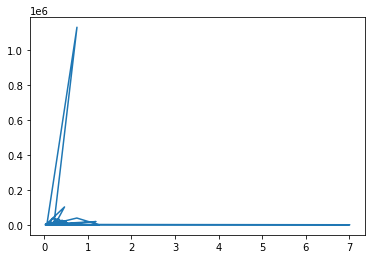

In [15]:
plt.plot(total_joined_df['num_mods'] / total_joined_df['time_diff_float'], total_joined_df['num_subscribers'] / total_joined_df['time_diff_float'], '-')
plt.show()

In [16]:
total_joined_df['log_subs'] = np.log(total_joined_df['num_subscribers'])
total_joined_df['log_mods'] = np.log(total_joined_df['num_mods'])
total_joined_df['log_mods_gained'] = np.log(total_joined_df['mods_gained'])
total_joined_df['log_mods_lost'] = np.log(total_joined_df['mods_lost'])

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='num_subscribers', ylabel='num_mods'>

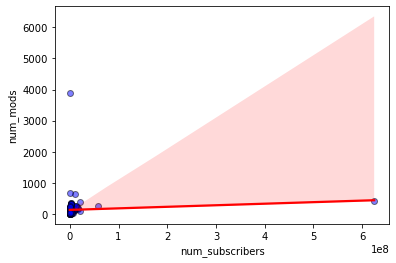

In [17]:
sns.regplot(y = "num_mods", x = "num_subscribers",
    scatter_kws = {"color":"blue", "alpha":0.5, "edgecolor":"black"},
    line_kws={"color":"red"},
    data=total_joined_df)

<AxesSubplot:xlabel='log_subs', ylabel='log_mods'>

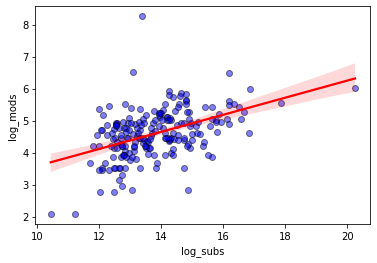

In [18]:
sns.regplot(y = "log_mods", x = "log_subs",
    scatter_kws = {"color":"blue", "alpha":0.5, "edgecolor":"black"},
    line_kws={"color":"red"},
    data=total_joined_df)

<AxesSubplot:xlabel='mods_gained', ylabel='log_subs'>

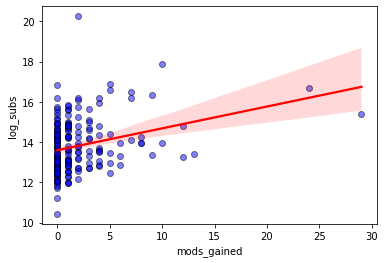

In [19]:
sns.regplot(y = "log_subs", x = "mods_gained",
    scatter_kws = {"color":"blue", "alpha":0.5, "edgecolor":"black"},
    line_kws={"color":"red"},
    data=total_joined_df)

<AxesSubplot:xlabel='mods_lost', ylabel='log_subs'>

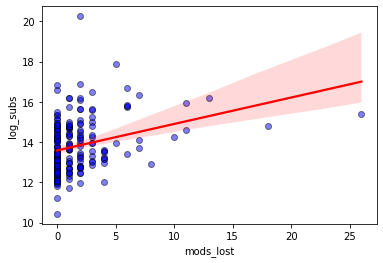

In [20]:
sns.regplot(y = "log_subs", x = "mods_lost",
    scatter_kws = {"color":"blue", "alpha":0.5, "edgecolor":"black"},
    line_kws={"color":"red"},
    data=total_joined_df)